# Deep fake detection Proof of concept

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm #progress meter
%matplotlib inline 
import cv2 
from PIL import Image

import torch # if neural networks
from torch import nn
import torch.nn.functional as F
import torchvision #cnn
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms 
from torch import optim
from sklearn.model_selection import train_test_split
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Data  and function exploration

In [2]:
#DATA_FOLDER = '../input/deepfake-detection-challenge'
nDataFolder = 'data'
TRAIN_SAMPLE_FOLDER = 'train_part0'
TEST_FOLDER = 'test_videos'
print(f"Train samples: {len(os.listdir(os.path.join(nDataFolder, TRAIN_SAMPLE_FOLDER)))}")
print(f"Test samples: {len(os.listdir(os.path.join(nDataFolder, TEST_FOLDER)))}")
train_df = pd.read_json(os.path.join(nDataFolder, TRAIN_SAMPLE_FOLDER, 'metadata.json'))
train_df = train_df.T
train_df.head(3)

Train samples: 1335
Test samples: 400


label  split        original
owxbbpjpch.mp4  FAKE  train  wynotylpnm.mp4
vpmyeepbep.mp4  REAL  train             NaN
fzvpbrzssi.mp4  REAL  train             NaN

In [3]:
test_df = pd.DataFrame(list(os.listdir(os.path.join(nDataFolder, TEST_FOLDER))), columns=['video'])
test_df.head(3)

video
0  hclsparpth.mp4
1  bcbqxhziqz.mp4
2  zmxeiipnqb.mp4

In [4]:
filename = os.path.join(nDataFolder, TRAIN_SAMPLE_FOLDER, train_df.index[1])
video_o = cv2.VideoCapture(filename)
video_l = int(video_o.get(cv2.CAP_PROP_FRAME_COUNT))
video_w= int(video_o.get(cv2.CAP_PROP_FRAME_WIDTH))
video_h= int(video_o.get(cv2.CAP_PROP_FRAME_HEIGHT))
print(video_l,video_w,video_h)

300 1080 1920


In [5]:
success,frame = video_o.read()
frame.shape

(1920, 1080, 3)

# Proof of concept

In [6]:
!pip install facenet-pytorch

In [7]:
from facenet_pytorch import MTCNN, InceptionResnetV1

In [8]:
# Load face detector
mtcnn = MTCNN(margin=14, keep_all=True, device=device).eval()
# Load facial recognition model
resnet = InceptionResnetV1(pretrained='vggface2', device=device).eval()

In [9]:
nTrainDir = 'train_part0'
train_df = pd.read_json(os.path.join(nDataFolder, nTrainDir, 'metadata.json'))
train_df = train_df.T
train_df_false = train_df [train_df.label == 'FAKE']
train_df_false.head()

label  split        original
owxbbpjpch.mp4  FAKE  train  wynotylpnm.mp4
htorvhbcae.mp4  FAKE  train  wclvkepakb.mp4
fckxaqjbxk.mp4  FAKE  train  vpmyeepbep.mp4
sphirandia.mp4  FAKE  train  jawgcggquk.mp4
vsmadeuczx.mp4  FAKE  train  qarqtkvgby.mp4

In [10]:
filename = os.path.join(nDataFolder, nTrainDir, train_df_false.index[1])
filename_org = os.path.join(nDataFolder, nTrainDir,train_df_false.original[1])
print(filename,filename_org)

data/train_part0/htorvhbcae.mp4 data/train_part0/wclvkepakb.mp4


In [11]:
def get_face (filename):
    torch.cuda.empty_cache()
    video_o = cv2.VideoCapture(filename)
    success = video_o.grab()
    success, frame = video_o.retrieve()
    if  success:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = Image.fromarray(frame)
        Face = mtcnn(frame) ##TODO addd success decision and also batch selection
    video_o.release()
    return Face[0]

fake image


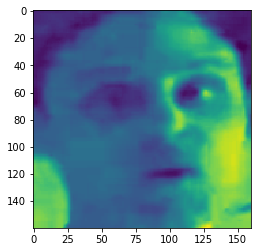

In [12]:
face = get_face(filename)
print('fake image')
plt.imshow(face[-1])

orginal image


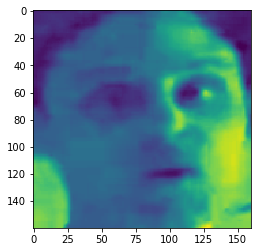

In [13]:
face_org = get_face(filename_org)
print('orginal image')
plt.imshow(face[-1])

In [14]:
#iterate for each video 
torch.cuda.empty_cache()
# Load face detector
mtcnn = MTCNN(margin=14, keep_all=True, device=device).eval()
def get_faces (filename, n_frames = 17):
    video_o = cv2.VideoCapture(filename)#get video 
    #get the lenght and divide inthe specified dataframes
    video_len = int(video_o.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_index_list = np.linspace(0, video_len - 1, n_frames).astype(int)
    face_batch = torch.tensor((),dtype = torch.float32)
    for frame_indx in range(video_len):
        if frame_indx in frame_index_list:
            success = video_o.grab()
            success, frame = video_o.retrieve()
            if  success: 
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = Image.fromarray(frame)
                Face = mtcnn(frame) # succes will not be considered to train with noise data too
            else:
                Face = torch.tensor((),dtype = torch.float32)
                Face = Face.new_zeros([1, 3, 160, 160])
                
            if Face is None:
                Face = torch.tensor((),dtype = torch.float32)
                Face = Face.new_zeros([1, 3, 160, 160])
                
            face_batch = torch.cat((face_batch,Face))
            if len(face_batch) > n_frames:
                face_batch  = face_batch[:n_frames]
                
    video_o.release()
    return face_batch



In [15]:
a = torch.randn(4, 4)
print(a)
print(torch.mean(a,dim =1))
print(torch.mean(a,dim =0))

tensor([[-0.4811, -1.3337,  1.0939,  1.7909],
        [-0.3686,  0.7570,  0.4066,  0.2779],
        [-0.1075,  0.3391, -1.4270, -0.3460],
        [-0.8338,  0.7006,  0.0121, -0.6791]])
tensor([ 0.2675,  0.2682, -0.3853, -0.2000])
tensor([-0.4477,  0.1158,  0.0214,  0.2610])


In [16]:
resnet = InceptionResnetV1(pretrained='vggface2', device=device).eval() 
torch.cuda.empty_cache()
def get_video_embedding(filename):
    faces = get_faces(filename,n_frames =17)
    embe = resnet(faces.to(device))
    return torch.mean(embe,dim = 0)



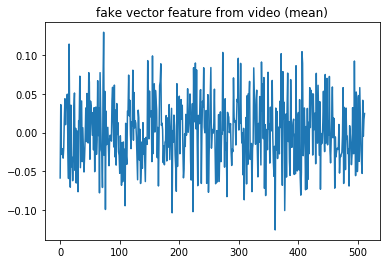

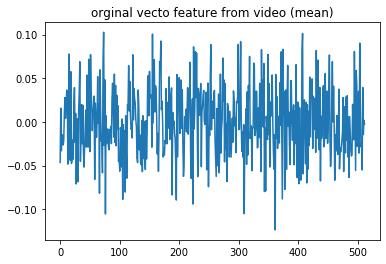

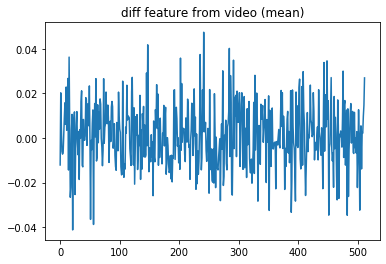

In [17]:

#test 
filename = os.path.join(nDataFolder, nTrainDir, train_df_false.index[1])
filename_org = os.path.join(nDataFolder, nTrainDir,train_df_false.original[1])
mean_fake = get_video_embedding(filename)
mean_org  = get_video_embedding(filename_org)

#plt.plot(r[0].cpu().data.numpy()) # plotting by columns
#plt.show()


plt.plot(mean_fake.cpu().data.numpy()) # plotting by columns
plt.title('fake vector feature from video (mean)')
plt.show()

plt.plot(mean_org.cpu().data.numpy()) # plotting by columns
plt.title('orginal vecto feature from video (mean)')
plt.show()

plt.plot(mean_fake.cpu().data.numpy() - mean_org.cpu().data.numpy()) # plotting by columns
plt.title('diff feature from video (mean)')
plt.show()

In [18]:
mean_fake.shape

torch.Size([512])

In [19]:
#Now define the model to output if fake or not 
class FakeClassifier(nn.Module):
    def __init__(self):
        super(FakeClassifier,self).__init__()
        self.hidden0 = nn.Sequential(
            nn.Linear(512,256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3))
        self.hidden1 = nn.Sequential(
            nn.Linear(256,128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3))
        self.hidden2 = nn.Sequential(
            nn.Linear(128,64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3))
        self.hidden3 = nn.Sequential(
            nn.Linear(64,32),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3))
        self.out =  nn.Linear(32,1) #BCELoss
       # self.out =  nn.Linear(32,2) #CrossEntropyLoss
        
    def forward(self,x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        x = self.out(x)
        return x

In [26]:
fake_classifier = FakeClassifier().to(device)
classifier_adam_optim = optim.Adam(fake_classifier.parameters(),lr = 0.01)
criterion_BCE = nn.BCEWithLogitsLoss()
criterion_CEL = nn.CrossEntropyLoss()

In [27]:
#Normal Solution 
torch.cuda.empty_cache()
fake_classifier.train()
filename = os.path.join(nDataFolder, nTrainDir, train_df_false.index[1])
filename_org = os.path.join(nDataFolder, nTrainDir,train_df_false.original[1])
mean_fake = get_video_embedding(filename)
mean_org  = get_video_embedding(filename_org)
mean_fake.detach_()
mean_org.detach_()

nOverfitEpochs = 100
for indx in tqdm(range(nOverfitEpochs)):
   
    fake_tensor = torch.randint(7,12,(1,1),requires_grad = False,dtype = torch.float32)/10.0
    fake_tensor =fake_tensor[0]
    true_tensor = torch.randint(0,3,(1,1),requires_grad = False,dtype = torch.float32)/10.0
    true_tensor = true_tensor[0]
    #train on fake
    classifier_adam_optim.zero_grad()
    out_class = fake_classifier(mean_fake[None].to(device))
    #loss = criterion_CEL(out_class,fake_tensor.to(device))
    loss_f = criterion_BCE(out_class,fake_tensor[None].to(device))
    loss_f.backward()
   # classifier_adam_optim.step()
    #classifier_adam_optim.zero_grad()
    if indx%2 == 0:
        out_class_o = fake_classifier(mean_org[None].to(device))
        #loss = criterion_CEL(out_class_o,true_tensor.to(device))
        loss_o = criterion_BCE(out_class_o,true_tensor[None].to(device)) 
        loss_o.backward()
        loss_o = loss_o + loss_f
        #loss_o.backward()
    classifier_adam_optim.step()
  
print(fake_tensor,true_tensor)
print(loss_o.item())
print(torch.sigmoid(out_class))
#print(out_class)


100%|██████████| 100/100 [00:00<00:00, 318.50it/s]

tensor([0.7000]) tensor([0.2000])
1.1435824632644653
tensor([[0.9307]], device='cuda:0', grad_fn=<SigmoidBackward>)


In [29]:

#batched solution
torch.cuda.empty_cache()
fake_classifier.train()
train_videos,eval_videos,y_train,eval_y  = train_test_split(train_df_false,train_df_false.label,train_size = 0.3,random_state =3)     
indx = 0
n_batch = 12

mean_batch_org = torch.tensor((),dtype = torch.float32).to(device)
mean_batch_fake = torch.tensor((),dtype = torch.float32).to(device)
for video_name,video in train_videos.iterrows():#tqdm(
    indx = indx +1
    print(indx)
    filename = os.path.join(nDataFolder, nTrainDir, video_name)
    filename_org = os.path.join(nDataFolder, nTrainDir,video.original)
    mean_fake = get_video_embedding(filename)
    mean_org  = get_video_embedding(filename_org)
    mean_fake.detach_()
    mean_org.detach_()
    mean_fake = mean_fake[None]
    mean_org = mean_org[None]
    mean_batch_fake = torch.cat((mean_batch_fake,mean_fake))
    mean_batch_org = torch.cat((mean_batch_org,mean_org))
    if indx >n_batch:
        nOverfitEpochs = 100
        for indx in tqdm(range(nOverfitEpochs)):

            
            #train on fake
            classifier_adam_optim.zero_grad()
            out_class = fake_classifier(mean_batch_fake.to(device))
            fake_tensor =torch.randint_like(out_class,7,12,requires_grad = False,dtype = torch.float32)/10.0
            
            true_tensor = torch.randint_like(out_class,0,3,requires_grad = False,dtype = torch.float32)/10.0
            #loss = criterion_CEL(out_class,fake_tensor.to(device))
            loss_f = criterion_BCE(out_class,fake_tensor.to(device))
            loss_f.backward()
           # classifier_adam_optim.step()
            #classifier_adam_optim.zero_grad()
            if indx%1 == 0:
                out_class_o = fake_classifier(mean_batch_org.to(device))
                #loss = criterion_CEL(out_class_o,true_tensor.to(device))
                loss_o = criterion_BCE(out_class_o,true_tensor.to(device)) 
                loss_o.backward()
                loss_o = loss_o + loss_f
            classifier_adam_optim.step()
        break
  
print(fake_tensor,true_tensor)
print(loss_o.item())
print(torch.sigmoid(out_class))
#print(out_class)


1
2
3
4
5
6
7
8
9
10
11
12
13


100%|██████████| 100/100 [00:00<00:00, 348.80it/s]

tensor([[0.8000],
        [0.7000],
        [0.8000],
        [1.0000],
        [1.0000],
        [0.7000],
        [1.0000],
        [1.0000],
        [1.1000],
        [0.8000],
        [0.9000],
        [0.7000],
        [0.8000]], device='cuda:0') tensor([[0.1000],
        [0.2000],
        [0.2000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.2000],
        [0.2000],
        [0.1000],
        [0.0000],
        [0.1000],
        [0.2000]], device='cuda:0')
0.7932142019271851
tensor([[0.9595],
        [0.9308],
        [0.9296],
        [0.8143],
        [0.9143],
        [0.8549],
        [0.8550],
        [0.8523],
        [0.8477],
        [0.6818],
        [0.9062],
        [0.8556],
        [0.8671]], device='cuda:0', grad_fn=<SigmoidBackward>)


In [28]:
fake_classifier.eval()
print('prediction on fake  ',torch.sigmoid(fake_classifier(mean_fake[None].to(device)) ) )
print('prediction on original  ',torch.sigmoid(fake_classifier(mean_org[None].to(device)) ) )

prediction on fake   tensor([[0.9661]], device='cuda:0', grad_fn=<SigmoidBackward>)
prediction on original   tensor([[0.1695]], device='cuda:0', grad_fn=<SigmoidBackward>)
